# 1D Langevin Process Simulation

This notebook simulates a 1-dimensional Langevin process with temperature-scaled noise to achieve a target Gaussian equilibrium distribution with variance 0.43.

**Langevin Equation:**
$$dx = -\gamma x \, dt + \sqrt{2T} \, dW$$

where:
- $\gamma$ is the friction coefficient
- $T$ is the temperature
- $dW$ is the Wiener process increment (Gaussian noise)


In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

## Define the Langevin Dynamics Function

The Langevin equation describes overdamped dynamics in a potential. For a quadratic potential $V(x) = \frac{1}{2}\gamma x^2$, the equilibrium distribution is Gaussian with variance $\sigma^2 = \frac{T}{\gamma}$.

Using the Euler-Maruyama discretization scheme:
$$x_{n+1} = x_n - \gamma x_n \, dt + \sqrt{2T \, dt} \, \xi_n$$

where $\xi_n \sim \mathcal{N}(0, 1)$.


In [5]:
def langevin_step(x, gamma, T, dt):
    """
    Perform one step of the Langevin dynamics.
    
    Parameters:
    -----------
    x : float
        Current position
    gamma : float
        Friction coefficient (controls potential: V(x) = 0.5 * gamma * x^2)
    T : float
        Temperature
    dt : float
        Time step
    
    Returns:
    --------
    x_new : float
        Updated position
    """
    # Deterministic drift: -gamma * x * dt
    drift = -gamma * x * dt
    
    # Stochastic diffusion: sqrt(2 * T * dt) * N(0, 1)
    noise = np.sqrt(2 * T * dt) * np.random.normal(0, 1)
    
    x_new = x + drift + noise
    return x_new


def langevin_simulate(n_steps, gamma, T, dt, x0=0.0):
    """
    Simulate the Langevin process.
    
    Parameters:
    -----------
    n_steps : int
        Number of simulation steps
    gamma : float
        Friction coefficient
    T : float
        Temperature
    dt : float
        Time step
    x0 : float
        Initial position
    
    Returns:
    --------
    trajectory : ndarray
        Time series of positions
    """
    trajectory = np.zeros(n_steps)
    trajectory[0] = x0
    
    for i in range(1, n_steps):
        trajectory[i] = langevin_step(trajectory[i-1], gamma, T, dt)
    
    return trajectory


## Set Simulation Parameters

To achieve a target variance of 0.43, we need:
$$\sigma^2 = \frac{T}{\gamma} = 0.43$$

We can choose convenient values for $\gamma$ and $T$ that satisfy this relationship.


In [9]:
# Simulation parameters
target_variance = 0.43

# Choose friction coefficient
gamma = 1.0

# Calculate temperature to achieve target variance
# From equilibrium: variance = T / gamma
T = target_variance * gamma

# Time step (must be small enough for stability)
dt = 0.001

# Simulation parameters
n_equilibration_steps = 500000  # Steps to reach equilibrium
n_sampling_steps = 500000       # Steps to collect samples after equilibration
n_total_steps = n_equilibration_steps + n_sampling_steps

x0 = 0.0  # Initial position

print(f"Target variance: {target_variance}")
print(f"Friction coefficient (gamma): {gamma}")
print(f"Temperature (T): {T}")
print(f"Equilibrium variance (T/gamma): {T/gamma}")
print(f"Time step (dt): {dt}")
print(f"Total simulation steps: {n_total_steps}")
print(f"Theoretical std dev: {np.sqrt(target_variance):.6f}")


Target variance: 0.43
Friction coefficient (gamma): 1.0
Temperature (T): 0.43
Equilibrium variance (T/gamma): 0.43
Time step (dt): 0.001
Total simulation steps: 1000000
Theoretical std dev: 0.655744


## Run the Langevin Simulation

Execute the full simulation, including equilibration and sampling phases.


In [10]:
# Run simulation
print("Running Langevin simulation...")
trajectory = langevin_simulate(n_total_steps, gamma, T, dt, x0=x0)
print("Simulation complete!")

# Separate equilibration and sampling phases
equilibration_trajectory = trajectory[:n_equilibration_steps]
sampling_trajectory = trajectory[n_equilibration_steps:]

print(f"\nTrajectory statistics:")
print(f"Full trajectory - mean: {np.mean(trajectory):.6f}, std: {np.std(trajectory):.6f}")
print(f"Equilibration phase - mean: {np.mean(equilibration_trajectory):.6f}, std: {np.std(equilibration_trajectory):.6f}")
print(f"Sampling phase - mean: {np.mean(sampling_trajectory):.6f}, std: {np.std(sampling_trajectory):.6f}")
print(f"Sampling phase - variance: {np.var(sampling_trajectory):.6f}")


Running Langevin simulation...
Simulation complete!

Trajectory statistics:
Full trajectory - mean: -0.028201, std: 0.651706
Equilibration phase - mean: 0.000105, std: 0.667447
Sampling phase - mean: -0.056507, std: 0.634313
Sampling phase - variance: 0.402353


## Analyze the Equilibrium Distribution

Compute statistics of the sampling trajectory to verify it matches the target Gaussian distribution.


In [11]:
# Analysis of equilibrium distribution
print("=" * 60)
print("EQUILIBRIUM DISTRIBUTION ANALYSIS")
print("=" * 60)

# Compute statistics from sampling phase
empirical_mean = np.mean(sampling_trajectory)
empirical_std = np.std(sampling_trajectory)
empirical_variance = np.var(sampling_trajectory)

print(f"\nEmpirical statistics (sampling phase):")
print(f"  Mean: {empirical_mean:.6f}")
print(f"  Std dev: {empirical_std:.6f}")
print(f"  Variance: {empirical_variance:.6f}")

print(f"\nTheoretical (target) values:")
print(f"  Mean: 0.0 (by symmetry)")
print(f"  Std dev: {np.sqrt(target_variance):.6f}")
print(f"  Variance: {target_variance:.6f}")

print(f"\nRelative errors:")
print(f"  Mean error: {abs(empirical_mean):.6e}")
print(f"  Variance error: {abs(empirical_variance - target_variance) / target_variance * 100:.2f}%")

# Perform Kolmogorov-Smirnov test against theoretical Gaussian
ks_statistic, ks_pvalue = stats.kstest(sampling_trajectory, 'norm', 
                                        args=(empirical_mean, empirical_std))
print(f"\nKolmogorov-Smirnov test:")
print(f"  Test statistic: {ks_statistic:.6f}")
print(f"  P-value: {ks_pvalue:.6f}")

# Anderson-Darling test
anderson_result = stats.anderson(sampling_trajectory, dist='norm')
print(f"\nAnderson-Darling test:")
print(f"  Test statistic: {anderson_result.statistic:.6f}")
print(f"  Critical values: {anderson_result.critical_values}")
print(f"  Significance levels: {anderson_result.significance_level}")


EQUILIBRIUM DISTRIBUTION ANALYSIS

Empirical statistics (sampling phase):
  Mean: -0.056507
  Std dev: 0.634313
  Variance: 0.402353

Theoretical (target) values:
  Mean: 0.0 (by symmetry)
  Std dev: 0.655744
  Variance: 0.430000

Relative errors:
  Mean error: 5.650700e-02
  Variance error: 6.43%

Kolmogorov-Smirnov test:
  Test statistic: 0.007210
  P-value: 0.000000

Anderson-Darling test:
  Test statistic: 69.158672
  Critical values: [0.576 0.656 0.787 0.918 1.092]
  Significance levels: [15.  10.   5.   2.5  1. ]


## Visualize Results

Create comprehensive plots showing the trajectory, equilibrium distribution, and comparison with theory.


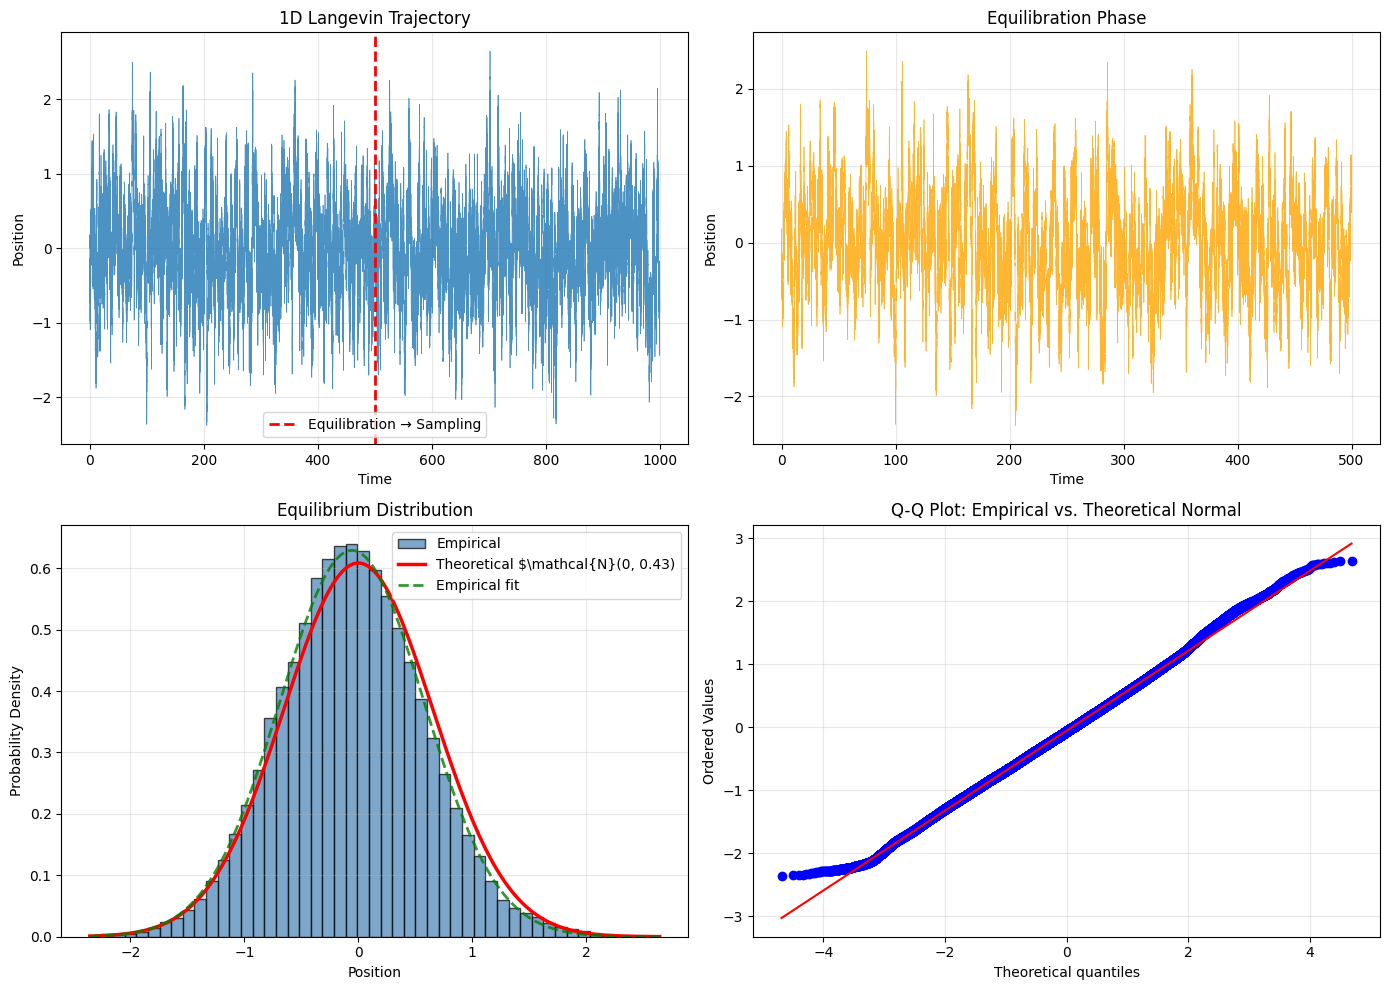

Figure saved to: /home/akiva/FCNX-Ensembling/plots/langevin_simulation_results.png


In [12]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Full trajectory
ax1 = axes[0, 0]
time_array = np.arange(len(trajectory)) * dt
ax1.plot(time_array, trajectory, linewidth=0.5, alpha=0.8)
ax1.axvline(x=n_equilibration_steps * dt, color='red', linestyle='--', 
            label='Equilibration → Sampling', linewidth=2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax1.set_title('1D Langevin Trajectory')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Trajectory during equilibration
ax2 = axes[0, 1]
time_equilibration = np.arange(len(equilibration_trajectory)) * dt
ax2.plot(time_equilibration, equilibration_trajectory, linewidth=0.5, alpha=0.8, color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('Position')
ax2.set_title('Equilibration Phase')
ax2.grid(True, alpha=0.3)

# Plot 3: Histogram with theoretical Gaussian overlay
ax3 = axes[1, 0]
bins = np.linspace(sampling_trajectory.min(), sampling_trajectory.max(), 50)
ax3.hist(sampling_trajectory, bins=bins, density=True, alpha=0.7, 
         color='steelblue', edgecolor='black', label='Empirical')

# Overlay theoretical Gaussian
x_theory = np.linspace(sampling_trajectory.min(), sampling_trajectory.max(), 200)
pdf_theory = norm.pdf(x_theory, loc=0, scale=np.sqrt(target_variance))
ax3.plot(x_theory, pdf_theory, 'r-', linewidth=2.5, label=f'Theoretical $\\mathcal{{N}}(0, {target_variance})')

# Overlay empirical Gaussian fit
pdf_empirical = norm.pdf(x_theory, loc=empirical_mean, scale=empirical_std)
ax3.plot(x_theory, pdf_empirical, 'g--', linewidth=2, label='Empirical fit', alpha=0.8)

ax3.set_xlabel('Position')
ax3.set_ylabel('Probability Density')
ax3.set_title('Equilibrium Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Q-Q plot (quantile-quantile plot)
ax4 = axes[1, 1]
stats.probplot(sampling_trajectory, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot: Empirical vs. Theoretical Normal')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/akiva/FCNX-Ensembling/plots/langevin_simulation_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved to: /home/akiva/FCNX-Ensembling/plots/langevin_simulation_results.png")

In [ ]:
# Additional visualization: Autocorrelation and convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot autocorrelation
ax1 = axes[0]
max_lag = min(500, len(sampling_trajectory) // 2)
lags = np.arange(max_lag)
autocorr = np.array([np.corrcoef(sampling_trajectory[:-lag], sampling_trajectory[lag:])[0, 1] 
                     if lag < len(sampling_trajectory) else 0 for lag in lags])
ax1.plot(lags, autocorr, linewidth=2, color='steelblue')
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Lag (steps)')
ax1.set_ylabel('Autocorrelation')
ax1.set_title('Autocorrelation Function')
ax1.grid(True, alpha=0.3)

# Plot running variance
ax2 = axes[1]
window_size = 500
running_variance = np.array([np.var(sampling_trajectory[max(0, i-window_size):i]) 
                             for i in range(window_size, len(sampling_trajectory))])
time_window = np.arange(window_size, len(sampling_trajectory)) * dt
ax2.plot(time_window, running_variance, linewidth=1.5, color='steelblue', alpha=0.8)
ax2.axhline(y=target_variance, color='red', linestyle='--', linewidth=2, 
            label=f'Target variance = {target_variance}')
ax2.axhline(y=empirical_variance, color='green', linestyle='--', linewidth=2, 
            label=f'Empirical mean = {empirical_variance:.6f}')
ax2.set_xlabel('Time')
ax2.set_ylabel('Running Variance')
ax2.set_title(f'Convergence to Target Variance (window={window_size} steps)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/akiva/FCNX-Ensembling/langevin_convergence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Convergence analysis figure saved to: /home/akiva/FCNX-Ensembling/langevin_convergence_analysis.png")
